# **Soft voting**


In [46]:
# Enviroment
isColab = False
colab_dir = "/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"

isKaggle = False
isWsl = True

# Set seed for reproducibility
SEED = 42

In [47]:
# Loader parameters
BATCH_SIZE = 32

NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

IMG_RESIZE = (224, 224)
INPUT_SHAPE = (3, *IMG_RESIZE)

In [48]:
EXPERIMENT_NAME = "efficientNetV2_S"
NET_NAME = "efficientnet"

# Fine tuning parameters
FT_DROPOUT_RATE = 0.3
K_FOLD = 2
TARGET_FOLD_INDEX = 1

## **Loading Enviroment**


In [49]:
import os

# Directory di default
current_dir = os.getcwd()   

if isColab:
    from google.colab import drive # type: ignore
    drive.mount("/gdrive")
    current_dir = colab_dir
    print("In esecuzione su Colab. Google Drive montato.")
    %cd $current_dir
elif isKaggle:
    kaggle_work_dir = "/kaggle/working/AN2DL-challenge-2"
    os.makedirs(kaggle_work_dir, exist_ok=True)
    current_dir = kaggle_work_dir
    print("In esecuzione su Kaggle. Directory di lavoro impostata.")
    os.chdir(current_dir)
elif isWsl:
    local_pref = r"/mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Esecuzione su WSL. Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)
else:
    print("Esecuzione locale. Salto mount Google Drive.")
    local_pref = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)

print(f"Changed directory to: {current_dir}")

# Define absolute paths
dataset_dir = os.path.join(current_dir, "dataset")
train_set_dir = os.path.join(dataset_dir, "train_data")
test_set_dir = os.path.join(dataset_dir, "test_data")
label_file = os.path.join(dataset_dir, "train_labels.csv")

print(f"Dataset directory: {dataset_dir}")
print(f"Train set directory: {train_set_dir}")
print(f"Test set directory: {test_set_dir}")
print(f"Label file: {label_file}")

Esecuzione su WSL. Directory corrente impostata a: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2
Changed directory to: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2
Dataset directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset
Train set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_data
Test set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/test_data
Label file: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_labels.csv


## **Import Libraries**


In [50]:
# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
%pip install torchview
from torchview import draw_graph


# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
if isColab or isKaggle:
    !pkill -f tensorboard 
    !mkdir -p models
    print("Killed existing TensorBoard instances and created models directory.") 

os.makedirs("models", exist_ok=True)  

%load_ext tensorboard


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
from scipy import ndimage
from torch.optim import AdamW

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.1+cu130
Device: cuda


### **Preparing Dataset for colab**

In [51]:
if isColab:
    drive_dataset_dir = os.path.join(current_dir, "dataset")
    local_dataset_dir = "/content/dataset"

    if not os.path.exists(local_dataset_dir):
        print(f"Copying dataset from {drive_dataset_dir} to {local_dataset_dir}...")
        try:
            shutil.copytree(drive_dataset_dir, local_dataset_dir)
            print("Copy complete.")
        except Exception as e:
            print(f"Error copying dataset: {e}")
            print("Falling back to Drive dataset (slow).")
            # If copy fails, we stick to the original dataset_dir (which might need cleaning too if it was used directly)
            dataset_dir = drive_dataset_dir
    else:
        print("Dataset already copied to local runtime.")

    # If copy succeeded (or already existed), use local path
    if os.path.exists(local_dataset_dir):
        dataset_dir = local_dataset_dir

## ⏳ **Data Loading**


### **Definitions**


In [52]:
SAMPLES_TO_IGNORE = [
    "img_0001.png",
    "img_0005.png",
    "img_0008.png",
    "img_0012.png",
    "img_0018.png",
    "img_0020.png",
    "img_0022.png",
    "img_0027.png",
    "img_0028.png",
    "img_0036.png",
    "img_0044.png",
    "img_0047.png",
    "img_0048.png",
    "img_0052.png",
    "img_0062.png",
    "img_0078.png",
    "img_0085.png",
    "img_0090.png",
    "img_0094.png",
    "img_0095.png",
    "img_0126.png",
    "img_0129.png",
    "img_0130.png",
    "img_0133.png",
    "img_0136.png",
    "img_0138.png",
    "img_0148.png",
    "img_0150.png",
    "img_0155.png",
    "img_0159.png",
    "img_0161.png",
    "img_0175.png",
    "img_0178.png",
    "img_0179.png",
    "img_0180.png",
    "img_0184.png",
    "img_0187.png",
    "img_0189.png",
    "img_0193.png",
    "img_0196.png",
    "img_0222.png",
    "img_0251.png",
    "img_0254.png",
    "img_0263.png",
    "img_0268.png",
    "img_0286.png",
    "img_0293.png",
    "img_0313.png",
    "img_0319.png",
    "img_0333.png",
    "img_0342.png",
    "img_0344.png",
    "img_0346.png",
    "img_0355.png",
    "img_0368.png",
    "img_0371.png",
    "img_0376.png",
    "img_0380.png",
    "img_0390.png",
    "img_0393.png",
    "img_0407.png",
    "img_0410.png",
    "img_0415.png",
    "img_0424.png",
    "img_0443.png",
    "img_0453.png",
    "img_0459.png",
    "img_0463.png",
    "img_0486.png",
    "img_0497.png",
    "img_0498.png",
    "img_0499.png",
    "img_0509.png",
    "img_0521.png",
    "img_0530.png",
    "img_0531.png",
    "img_0533.png",
    "img_0537.png",
    "img_0540.png",
    "img_0544.png",
    "img_0547.png",
    "img_0557.png",
    "img_0558.png",
    "img_0560.png",
    "img_0565.png",
    "img_0567.png",
    "img_0572.png",
    "img_0578.png",
    "img_0580.png",
    "img_0586.png",
    "img_0602.png",
    "img_0603.png",
    "img_0607.png",
    "img_0609.png",
    "img_0614.png",
    "img_0620.png",
    "img_0623.png",
    "img_0629.png",
    "img_0635.png",
    "img_0639.png",
    "img_0643.png",
    "img_0644.png",
    "img_0645.png",
    "img_0646.png",
    "img_0656.png",
    "img_0657.png",
    "img_0658.png",
    "img_0670.png",
    "img_0673.png",
    "img_0675.png",
]

In [53]:
# Load the full dataframe
full_df = pd.read_csv(label_file)

# Remove cursed images
full_df = full_df[~full_df["sample_index"].isin(SAMPLES_TO_IGNORE)].reset_index(
    drop=True
)

# Label mapping
class_names = sorted(full_df["label"].unique())
label_to_index = {name: idx for idx, name in enumerate(class_names)}
full_df["label_index"] = full_df["label"].map(label_to_index)
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [54]:
def make_loader(ds, batch_size, shuffle, drop_last=False):
    """Create a PyTorch DataLoader with optimized settings."""
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(6, cpu_cores))

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,
        persistent_workers=isWsl,
    )

In [55]:
from scipy import ndimage
from PIL import Image, ImageOps
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from torchvision.transforms import v2 as transforms


class MaskedFixedTileDataset(Dataset):
    """
    A Dataset class that extracts fixed-size patches from the center of tissue masks
    to preserve biological scale (magnification), rather than resizing variable crops.
    """

    def __init__(
        self, dataframe, img_dir, transforms=None, target_size=(224, 224), debug_max=None
    ):
        self.samples = []
        self.transforms = transforms
        self.img_dir = img_dir
        self.target_size = target_size

        # Handling inference mode (no labels) vs training mode
        self.is_inference_mode = False
        if dataframe is None or "label_index" not in dataframe.columns:
            self.is_inference_mode = True
            if dataframe is None:
                # If just a directory, list images
                img_names = sorted(
                    [f for f in os.listdir(img_dir) if f.startswith("img_")]
                )
            else:
                img_names = dataframe["sample_index"].tolist()
            iterator = zip(img_names, [-1] * len(img_names))
            total_items = len(img_names)
        else:
            iterator = zip(dataframe["sample_index"], dataframe["label_index"])
            total_items = len(dataframe)

        print(
            f"Processing {total_items} images to extract fixed-size {target_size} tiles..."
        )

        count = 0
        for img_name, label in tqdm(iterator, total=total_items):
            if debug_max and count >= debug_max:
                break
            self._process_and_extract(img_name, label)
            count += 1

        print(f"Extraction complete. Total patches: {len(self.samples)}")

    def _process_and_extract(self, img_name, label):
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.img_dir, img_name.replace("img_", "mask_"))

        try:
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
        except Exception as e:
            print(f"Warning: Could not load {img_name}: {e}")
            return

        img_w, img_h = image.size
        # Create binary mask for component labeling
        mask_arr = np.array(mask) > 0

        # Label connected components (blobs) in the mask
        labeled_mask, n_components = ndimage.label(mask_arr) # type: ignore

        for cid in range(1, n_components + 1):
            # Extract coordinates of the current blob
            ys, xs = np.where(labeled_mask == cid)

            # Filter out very small noise artifacts (< 50 pixels)
            if len(xs) < 50:
                continue

            # Calculate the centroid (center of mass) of the blob
            cy, cx = int(np.mean(ys)), int(np.mean(xs))

            # Define the fixed-size crop window around the centroid
            th, tw = self.target_size
            half_h, half_w = th // 2, tw // 2

            y1 = cy - half_h
            y2 = cy + half_h
            x1 = cx - half_w
            x2 = cx + half_w

            # Handle Edge Cases: Calculate intersection with the actual image
            img_y1, img_y2 = max(0, y1), min(img_h, y2)
            img_x1, img_x2 = max(0, x1), min(img_w, x2)

            # Extract the valid region from the image
            patch_crop = image.crop((img_x1, img_y1, img_x2, img_y2))

            # Calculate required padding if the crop extended beyond image bounds
            pad_left = max(0, -x1)
            pad_top = max(0, -y1)
            pad_right = max(0, x2 - img_w)
            pad_bottom = max(0, y2 - img_h)

            # If padding is needed, pad with white (255) which is standard background in histology
            if pad_left > 0 or pad_top > 0 or pad_right > 0 or pad_bottom > 0:
                patch = ImageOps.expand(
                    patch_crop,
                    border=(pad_left, pad_top, pad_right, pad_bottom),
                    fill=255,
                )
            else:
                patch = patch_crop

            # Ensure precise size match (e.g., if rounding errors occurred)
            if patch.size != self.target_size:
                patch = patch.resize(self.target_size, Image.BICUBIC) # type: ignore

            # Store in RAM (Efficient for ~2k images yielding ~10k-20k patches)
            self.samples.append(
                {"patch": np.array(patch), "label": label, "parent": img_name}
            )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        img = Image.fromarray(item["patch"])
        label = item["label"]

        if self.transforms:
            img = self.transforms(img)

        return img, label, item["parent"]

In [56]:
def compute_dataset_stats(dataset_class, dataframe, img_dir, target_size):
    """
    Computes channel-wise Mean and Std on the dataset without any normalization applied.
    """
    print("Computing dataset Mean and Std (this may take a moment)...")

    # define a simple transform that only converts to tensor
    basic_transforms = transforms.Compose(
        [transforms.Resize(IMG_RESIZE), transforms.ToTensor()]
    )

    # Instantiate dataset temporarily
    temp_ds = dataset_class(dataframe, img_dir, transforms=basic_transforms, target_size=target_size)
    loader = make_loader(temp_ds, batch_size=BATCH_SIZE, shuffle=False)

    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for data, _, _ in tqdm(loader):
        batch_samples = data.size(0)
        # Flatten H and W to calculate stats per channel
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    print(f"\nDONE. Copy these values into your config:")
    print(f"NEW_MEAN = {mean.tolist()}") # type: ignore
    print(f"NEW_STD = {std.tolist()}") # type: ignore
    return mean.tolist(), std.tolist()  # type: ignore

In [57]:
print("Calculating stats on Training Data...")
    
# We use the class we just defined
custom_mean, custom_std = compute_dataset_stats(
        dataset_class=MaskedFixedTileDataset, 
        dataframe=full_df, 
        img_dir=train_set_dir,
        target_size=IMG_RESIZE,
    )

NORMALIZATION_MEAN = custom_mean
NORMALIZATION_STD = custom_std

Calculating stats on Training Data...
Computing dataset Mean and Std (this may take a moment)...
Processing 581 images to extract fixed-size (224, 224) tiles...


  0%|          | 0/581 [00:00<?, ?it/s]

Extraction complete. Total patches: 4955


  0%|          | 0/155 [00:00<?, ?it/s]


DONE. Copy these values into your config:
NEW_MEAN = [0.6673933863639832, 0.6174471974372864, 0.6541767120361328]
NEW_STD = [0.08422686159610748, 0.11849816143512726, 0.0835428312420845]


### **Trasforms**

In [58]:
# Define transformations

data_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_RESIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
    ]
)

## 🧮 **Network Parameters**


### **Custom Nets**

In [59]:
class EfficientNetCustom(nn.Module):
    """
    Instantiates EfficientNet-B0 with ImageNet weights.
    Replaces the classifier head with a high-dropout dense layer to prevent overfitting.
    """

    def __init__(self, num_classes, dropout_rate=0.4):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes

        self.weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
        self.backbone = torchvision.models.efficientnet_v2_s(weights=self.weights)
        
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(self.dropout_rate),
            nn.Linear(in_features, self.num_classes),  # type: ignore
        )
        self.freeze_backbone()
    
    def freeze_backbone(self):
        # Freeze all layers except the classifier head
        for name, param in self.backbone.named_parameters():
            if not name.startswith("classifier"):
                param.requires_grad = False
        # Ensure classifier params are trainable
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self, n_layers, all=False):
        if all:
            for param in self.backbone.parameters():
                param.requires_grad = True
            return
        # Unfreeze the last n_layers of the backbone (excluding classifier which is already trainable)
        child_counter = 0
        for child in reversed(list(self.backbone.children())):
            child_counter += 1
            if child_counter <= n_layers:
                for param in child.parameters():
                    param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

In [60]:
class DenseNetCustom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.4):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes

        self.weights = torchvision.models.DenseNet121_Weights.DEFAULT
        self.backbone = torchvision.models.densenet121(weights=self.weights)

        # DenseNet classifier is stored in .classifier
        in_features = self.backbone.classifier.in_features

        # Replace Classifier
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate), nn.Linear(in_features, num_classes)
        )

        self.freeze_backbone()

    def freeze_backbone(self):
        # Freeze all feature layers
        for param in self.backbone.features.parameters():
            param.requires_grad = False
        # Unfreeze classifier
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self, n_blocks, all=False):
        if all:
            for param in self.backbone.parameters():
                param.requires_grad = True
            return

        # Keep classifier trainable
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True

        # Unfreeze the last n_blocks within features
        children = list(self.backbone.features.children())
        total_children = len(children)
        if n_blocks <= 0:
            return

        start = max(0, total_children - n_blocks)
        for i in range(start, total_children):
            for param in children[i].parameters():
                param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

In [61]:
class CustomNet(nn.Module):
    """
    Wrapper that can interchange between DenseNetCustom and EfficientNetCustom.
    Keeps the same constructor signature used in the notebook:
    CustomNet(num_classes, dropout_rate, backbone=...)
    """

    def __init__(self, num_classes, dropout_rate=0.4, backbone="densenet121"):
        super().__init__()
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.backbone_name = backbone.lower()

        if self.backbone_name in ("densenet", "densenet121"):
            self.backbone = DenseNetCustom(
                num_classes=num_classes, dropout_rate=dropout_rate
            )
        elif self.backbone_name in (
            "efficientnet",
            "efficientnet_v2s",
            "efficientnetv2s",
        ):
            self.backbone = EfficientNetCustom(
                num_classes=num_classes, dropout_rate=dropout_rate
            )
        else:
            raise ValueError(
                f"Unsupported backbone '{backbone}'. Use 'densenet' or 'efficientnet'."
            )

    def freeze_backbone(self):
        # Delegate to underlying implementation
        if hasattr(self.backbone, "freeze_backbone"):
            self.backbone.freeze_backbone()

    def unfreeze_backbone(self, n_layers, all=False):
        # Delegate to underlying implementation
        if hasattr(self.backbone, "unfreeze_backbone"):
            self.backbone.unfreeze_backbone(n_layers, all=all)

    def forward(self, x):
        return self.backbone(x)

## **Load Model**

In [62]:
model_path = f"models/{EXPERIMENT_NAME}_fold{TARGET_FOLD_INDEX + 1}_ft_model.pt"

model = EfficientNetCustom(
    num_classes=num_classes, dropout_rate=FT_DROPOUT_RATE
)  # , backbone=NET_NAME

model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

print(f"Model loaded successfully from {model_path}")

Model loaded successfully from models/efficientNetV2_S_fold2_ft_model.pt


## **GRAD-CAM**

In [63]:
def unnormalize(img, mean, std):
    img = np.array(img, copy=True)
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return np.clip(img, 0, 1)

In [64]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2


def visualize_gradcam(model, dataset, img_index=None, target_layer=None):
    """
    Visualizes where the model is looking for a specific image using Grad-CAM.
    """
    # 1. Select an Image
    if img_index is None:
        img_index = random.randint(0, len(dataset) - 1)

    # Get image and label (and parent_id if available)
    img_tensor, label_idx, img_name = dataset[img_index]

    # 2. Preprocess for Model (Add Batch Dimension)
    input_tensor = img_tensor.unsqueeze(0).to(device)

    # 3. Identify Target Layer
    # For EfficientNetV2-S, the features are in model.backbone.features
    # The final layer before classifier is features[-1] (typically a Conv2d or BatchNorm)
    if target_layer is None:
        # EfficientNetV2 structure: features is a Sequential of MBConv blocks
        # Access the last MBConv block or the final conv layer
        target_layers = [model.backbone.features[-1]]

    # 4. Generate CAM with gradient tracking enabled
    cam = GradCAM(model=model, target_layers=target_layers)

    # Enable gradients for input (needed for GradCAM to work)
    input_tensor.requires_grad = True

    # Compute CAM
    # targets=None means maximize the predicted class probability
    with torch.enable_grad():
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)

    # 5. Visualization Setup
    # GradCAM needs the original image in RGB (0-1 float) for overlay
    # We must 'un-normalize' the tensor properly
    # Detach from computation graph and convert to numpy
    rgb_img = img_tensor.detach().cpu().numpy().transpose(1, 2, 0).astype(np.float32)
    rgb_img = unnormalize(rgb_img, NORMALIZATION_MEAN, NORMALIZATION_STD)

    # Overlay Heatmap
    visualization = show_cam_on_image(rgb_img, grayscale_cam[0, :], use_rgb=True)

    # 6. Plot
    true_label = class_names[label_idx]

    # Run simple inference to see what the model thinks
    with torch.no_grad():
        logits = model(img_tensor.unsqueeze(0).to(device))
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_idx = torch.argmax(probs).item()
        pred_label = class_names[pred_idx]
        conf = probs[0][pred_idx].item()

    plt.figure(figsize=(12, 6))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title(f"Original: {img_name}\nTrue: {true_label}")
    plt.axis("off")

    # GradCAM
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title(f"Grad-CAM Focus\nPred: {pred_label} ({conf:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [65]:
from sklearn.model_selection import StratifiedKFold

# 1. Configuration


print(f"Recovering Validation indices for Fold {TARGET_FOLD_INDEX + 1}...")

# 2. Recreate the Splitter
# CRITICAL: random_state must match the SEED used in run_k_fold_training
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=SEED)

# 3. Iterate to find the specific fold
# We loop through all splits until we hit the one matching (CURRENT_FOLD - 1)
val_indices = []

for fold_idx, (train_idx, val_idx) in enumerate(
    skf.split(full_df, full_df["label_index"])
):
    if fold_idx == (TARGET_FOLD_INDEX):  # Convert 1-based "Fold 1" to 0-based index
        val_indices = val_idx
        break

print(f"Found {len(val_indices)} validation images for Fold {TARGET_FOLD_INDEX + 1}.")

# 4. Create the Dataset using ONLY these indices
# We subset the dataframe using .iloc
fold_val_df = full_df.iloc[val_indices].reset_index(drop=True)

val_ds = MaskedFixedTileDataset(
    fold_val_df,
    train_set_dir,
    transforms=data_transforms,  # Use simple validation transforms (No Augmentation)
    target_size=IMG_RESIZE,
    debug_max=None,
)

print("Validation Dataset ready for Grad-CAM.")

Recovering Validation indices for Fold 2...
Found 290 validation images for Fold 2.
Processing 290 images to extract fixed-size (224, 224) tiles...


  0%|          | 0/290 [00:00<?, ?it/s]

Extraction complete. Total patches: 2456
Validation Dataset ready for Grad-CAM.


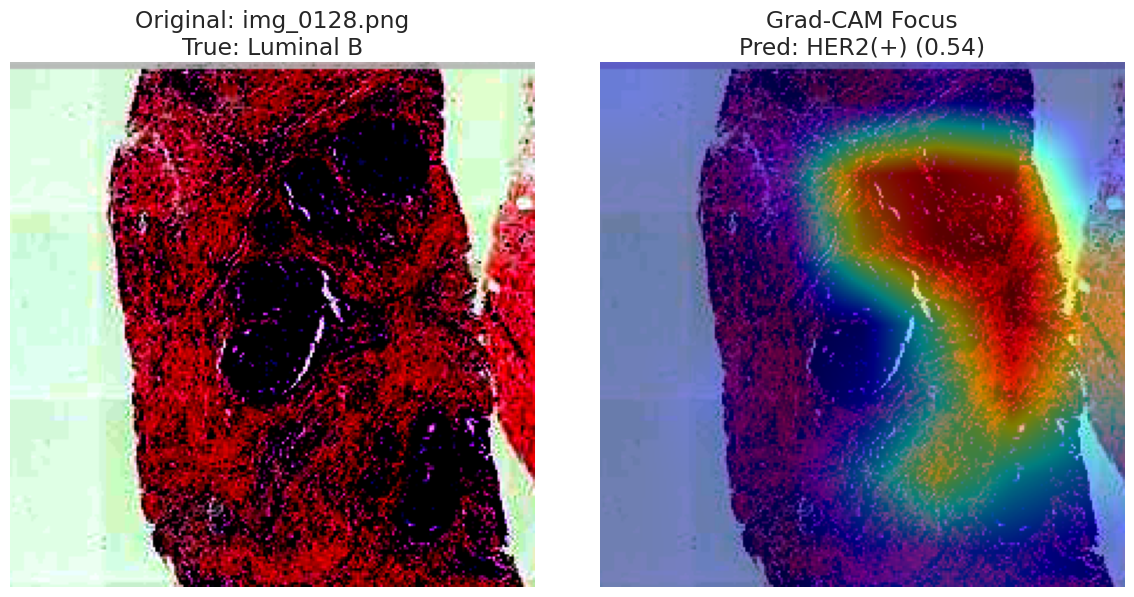

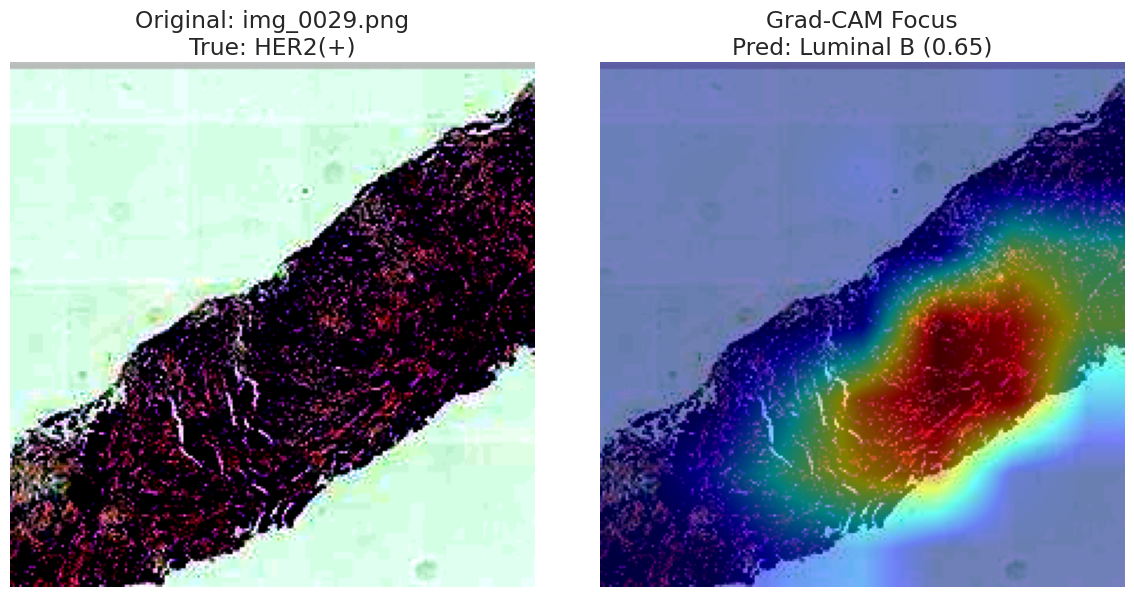

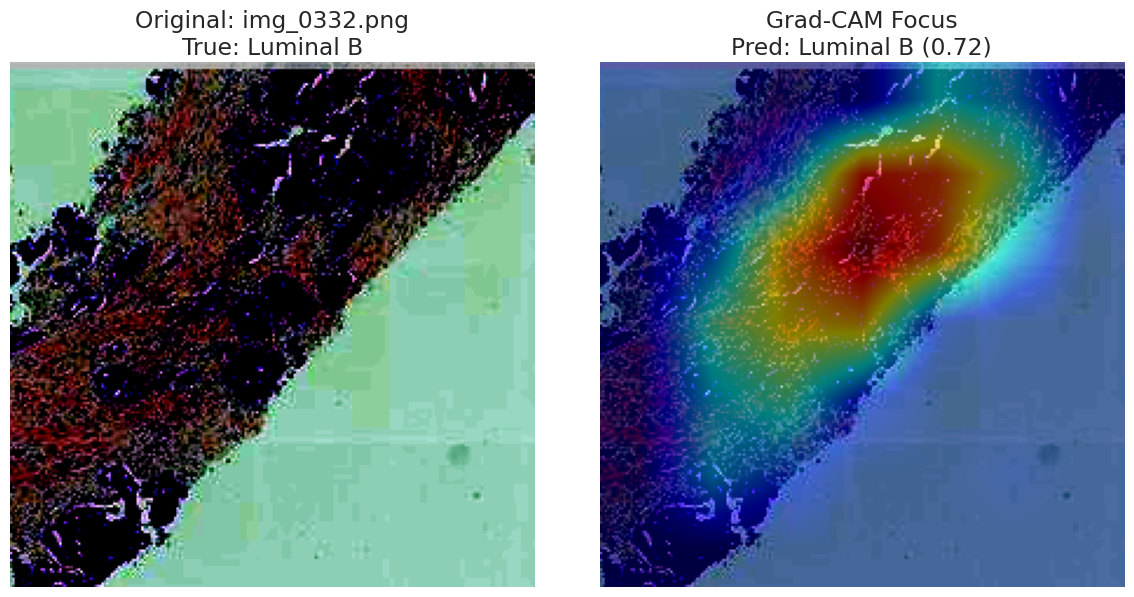

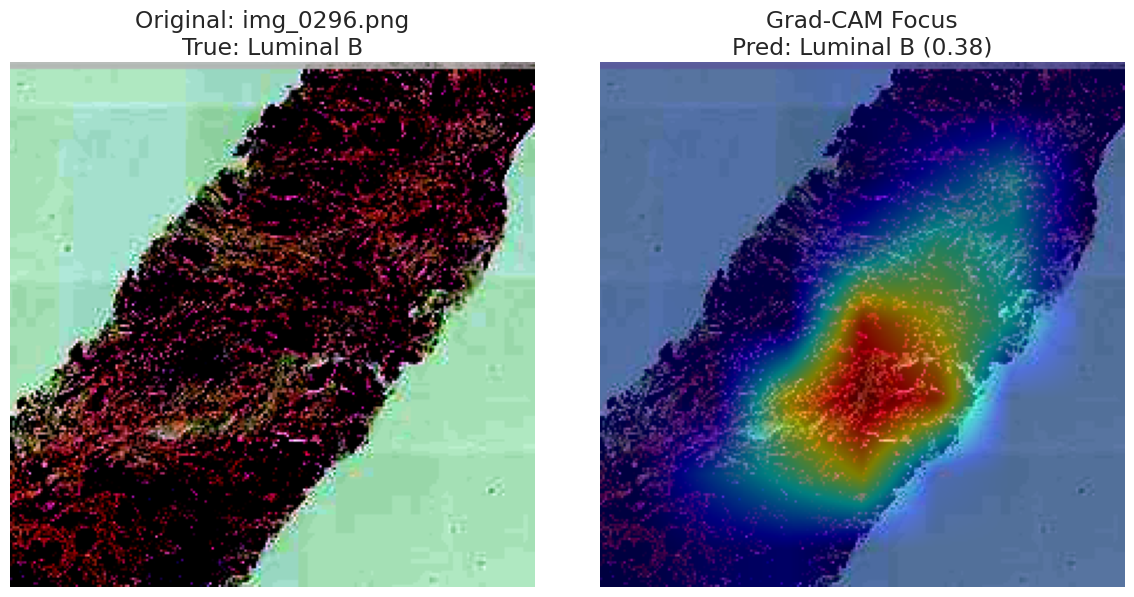

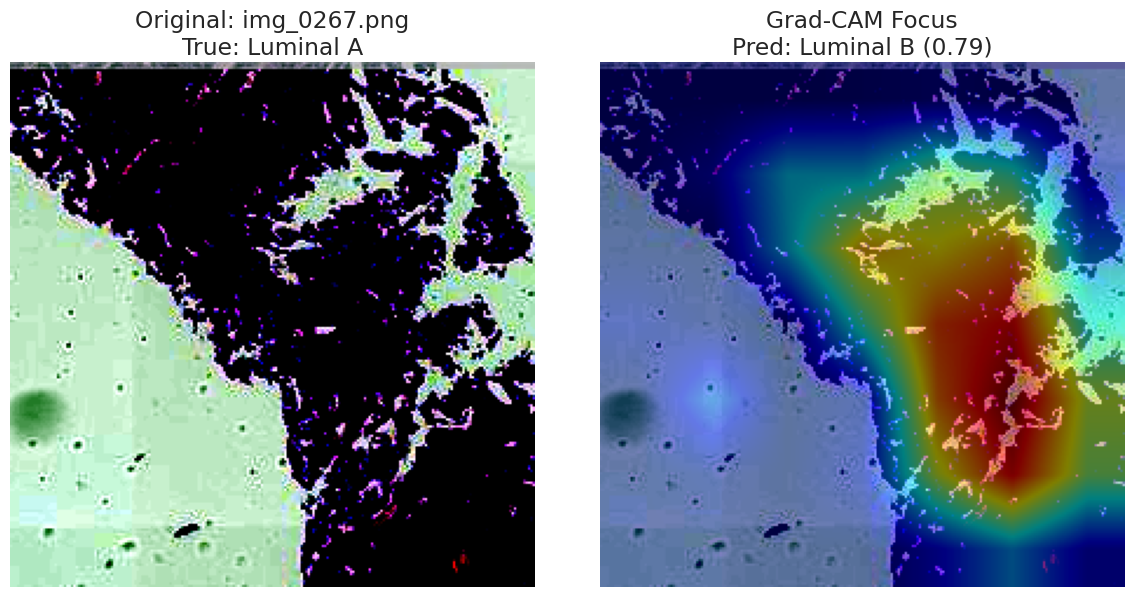

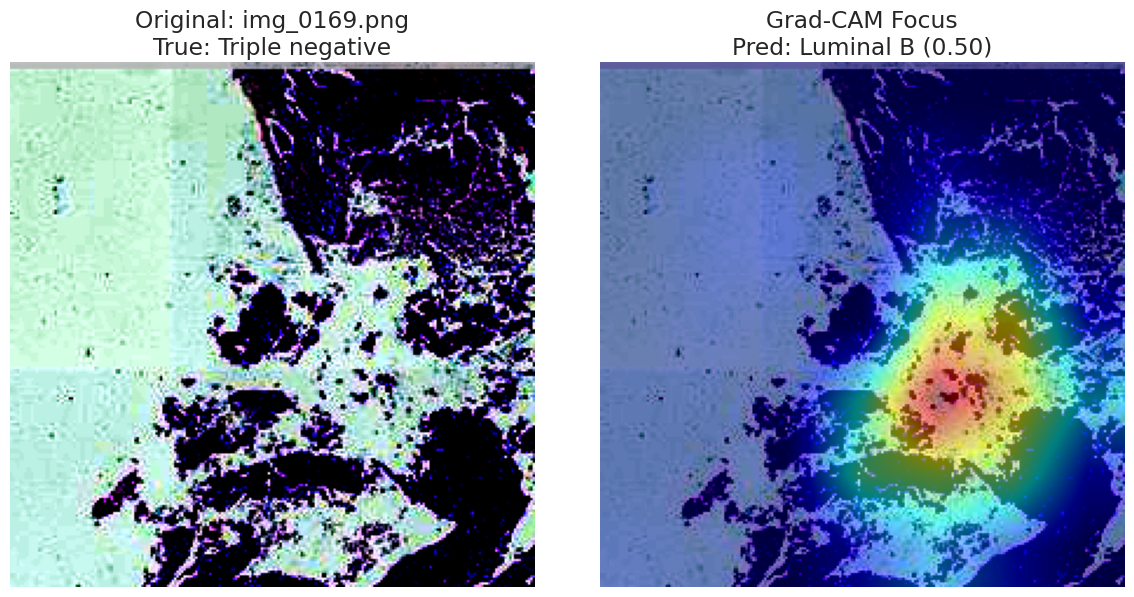

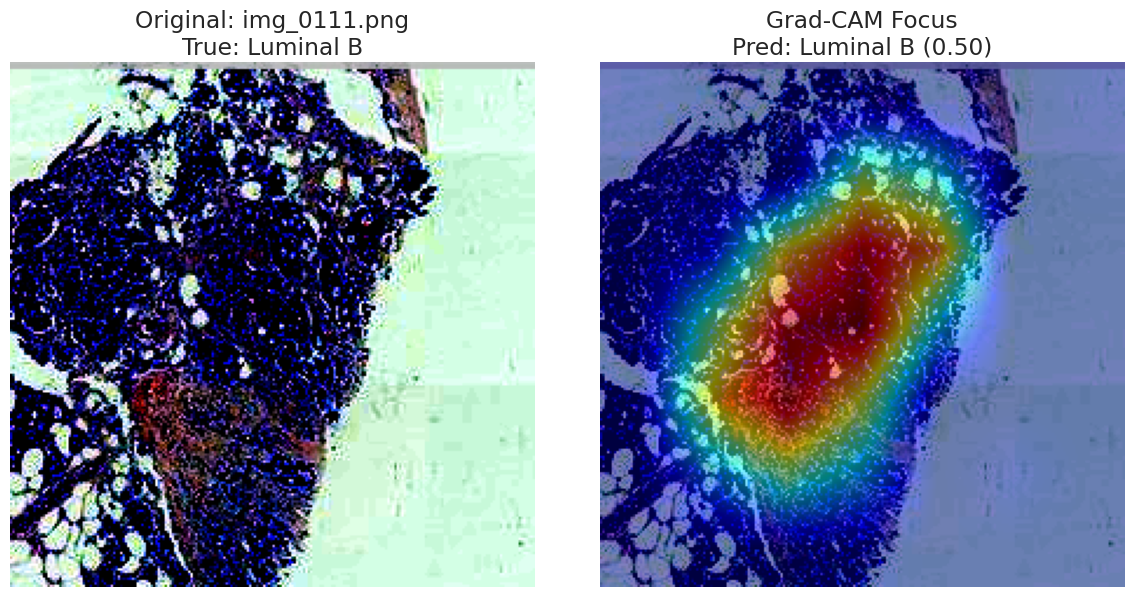

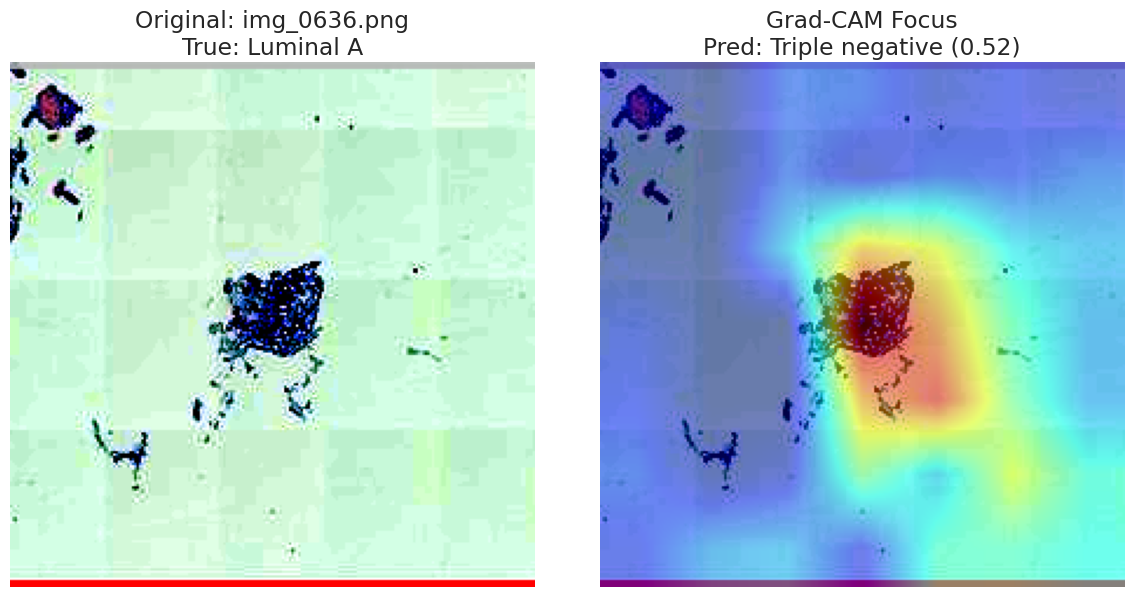

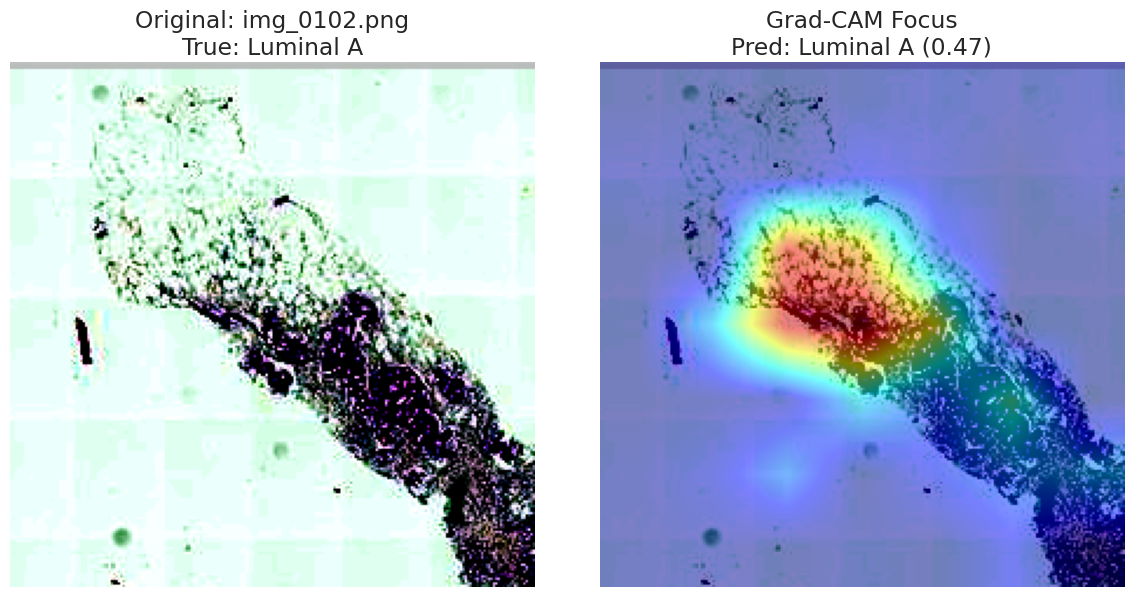

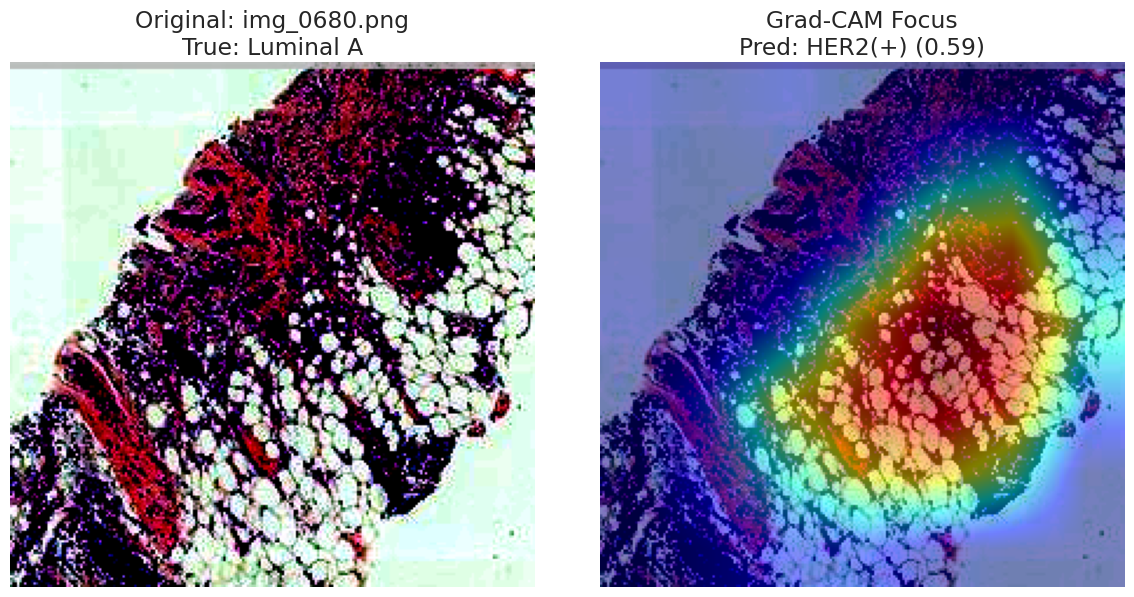

In [66]:
# Visualize a few random images
for _ in range(10):
    visualize_gradcam(model, val_ds)